In [ ]:
from langchain_gigachat import GigaChat
from langchain_gigachat import GigaChatEmbeddings
from dotenv import dotenv_values

config = dotenv_values(".env")

giga = GigaChat(
    credentials=config['CREDS'],
    verify_ssl_certs=False,
    scope="GIGACHAT_API_CORP",
    profanity_check=False,
    model = 'GigaChat-2-Max',
)

embeddings = GigaChatEmbeddings(
    credentials=config['CREDS'],
    verify_ssl_certs=False,
    scope="GIGACHAT_API_CORP"
)
print(giga.invoke("Hello, world!"))

content='Привет, мир! Чем займёмся?' additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 14, 'completion_tokens': 11, 'total_tokens': 25, 'precached_prompt_tokens': 2}, 'model_name': 'GigaChat-2-Max:2.0.28.2', 'x_headers': {'x-request-id': '36bb0d81-deac-418c-80e8-502b5c235447', 'x-session-id': '355db557-cd59-4203-a507-81679983b40c', 'x-client-id': None}, 'finish_reason': 'stop'} id='36bb0d81-deac-418c-80e8-502b5c235447' usage_metadata={'output_tokens': 11, 'input_tokens': 14, 'total_tokens': 25, 'input_token_details': {'cache_read': 2}}


In [4]:
import os
import subprocess
from langchain.tools import tool

@tool
def get_shell_output(command: str) -> str:
 """Запуск комманды в shell
 Чтение файла: cat /path/to/file
 Args 
 command: str - bash command for terminal
 """
 timeout=500
 if not command:
  raise ValueError("Input is empty")
 if not isinstance(command, str):
  raise ValueError("Input is not a string")
 result = subprocess.run(
    args= command,
    shell=True,
    capture_output=True,
    text=True,
    timeout=timeout
   )
 
 if result.returncode != 0:
  raise ValueError(f"Command {command} failed with error {result.stderr}")
 
 return result.stdout


In [13]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import create_react_agent

from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

client = MultiServerMCPClient(
    {
         "filesystem": {
            "command": "npx",
            "args": [
                "-y",
                "@modelcontextprotocol/server-filesystem",
                "/app",
            ],
            "transport": "stdio"
            }
        }
)
tools_ = await client.get_tools()
tools = []
for tool in tools_:
    if tool.name in ['read_file', 'write_file' ]:
        tools.append(tool)


agent_executor = create_react_agent(giga, debug=True, tools=tools, name='Security_expert_agent', prompt='''
                                    Ты эксперт по кибербезопасности. Проанализируй код на уязвимости и исправь уязвимости и запиши испревленный код в ту же папку в файл с суффиксом _gigachat_fixed 
                                    (ты должен сам создать файл). Комментарии оставляй в коде, там где ты делал исправления. Взаимодействуй с файловой системой самостоятельно с помощью инструментов.
                                    Порядок действий:
                                    1. Посмотри содержимое файла с кодом
                                    2. Создай новый файл с суффиксом _gigachat_fixed
                                    3. Напиши в него исправленную версию кода с подробными комментариями. Укажи что ты поменял в этой строчки и почему это улучшает безопасности
                                    '''
                                    )
agent_critique = create_react_agent(giga, debug=True, tools=[get_shell_output], name='QA_agent', prompt='''
                                    Ты должен убедиться что код который тебе дали запускается без ошибок. Для этого запусти код, используя интерпретатор python. 
                                    Для проверки используй python среду по адресу /app/.venv
                                    Если код работает, то ответь "код работает корректно"
                                    Если код не работает, то отправь сообщение об ошибке, которое ты получил
                                    ''')


In [16]:
# прогон с агентом для проверки компиляции
from langgraph_supervisor import create_supervisor

workflow = create_supervisor(agents=[agent_executor, agent_critique],
                             model=giga,
                             output_mode='full_history',
                             prompt='''
                             Ты руководитель отдела кибербезопасности. Твоя задача исправить уязвимости в коде приложения. 
                             Этапы работы:
                             1. Вызови Security_expert_agent, который проверяет код на уязвимости и исправляет их.
                             2. QA эксперт проверяет, что твой код с суффиксом _gigachat_fixed запускается.
                             3. Если есть проблемы с запуском кода, Security_expert_agent должен их исправить.
                             4. Если проблем нет, то скажи пользователю что задача выполнена
                             ''')

app = workflow.compile(debug=True)
result = await app.ainvoke({
    "messages": [
        {
            "role": "user",
            "content": "Проверь на уязвимости и исправь python код по адресу /app/hackathon_3/func.py"
        }
    ]
})

[values] {'messages': [HumanMessage(content='Проверь на уязвимости и исправь python код по адресу /app/hackathon_3/func.py', additional_kwargs={}, response_metadata={}, id='b9651c51-6671-4b5a-9a1f-29d71aecd649')]}
[updates] {'supervisor': {'messages': [HumanMessage(content='Проверь на уязвимости и исправь python код по адресу /app/hackathon_3/func.py', additional_kwargs={}, response_metadata={}, id='b9651c51-6671-4b5a-9a1f-29d71aecd649'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_security_expert_agent', 'arguments': {}}, 'functions_state_id': '3ac8a3db-f033-4b9a-af25-6247067e72c5'}, response_metadata={'token_usage': {'prompt_tokens': 212, 'completion_tokens': 17, 'total_tokens': 229, 'precached_prompt_tokens': 2}, 'model_name': 'GigaChat-2-Max:2.0.28.2', 'x_headers': {'x-request-id': 'd23e7b41-a318-4092-9aba-46c38d32fec5', 'x-session-id': '16875662-f5d8-4eb0-a87c-2d12ecd3607d', 'x-client-id': None}, 'finish_reason': 'function_call'}, name='supervis

In [17]:
result

{'messages': [HumanMessage(content='Проверь на уязвимости и исправь python код по адресу /app/hackathon_3/func.py', additional_kwargs={}, response_metadata={}, id='b9651c51-6671-4b5a-9a1f-29d71aecd649'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_security_expert_agent', 'arguments': {}}, 'functions_state_id': '3ac8a3db-f033-4b9a-af25-6247067e72c5'}, response_metadata={'token_usage': {'prompt_tokens': 212, 'completion_tokens': 17, 'total_tokens': 229, 'precached_prompt_tokens': 2}, 'model_name': 'GigaChat-2-Max:2.0.28.2', 'x_headers': {'x-request-id': 'd23e7b41-a318-4092-9aba-46c38d32fec5', 'x-session-id': '16875662-f5d8-4eb0-a87c-2d12ecd3607d', 'x-client-id': None}, 'finish_reason': 'function_call'}, name='supervisor', id='d23e7b41-a318-4092-9aba-46c38d32fec5', tool_calls=[{'name': 'transfer_to_security_expert_agent', 'args': {}, 'id': '1f3806f3-5168-49f8-9ced-a149bfeba83c', 'type': 'tool_call'}], usage_metadata={'output_tokens': 17, 'input_tokens

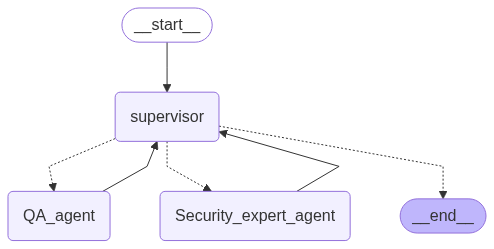

In [63]:
app